In [1]:
#Importing the required libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

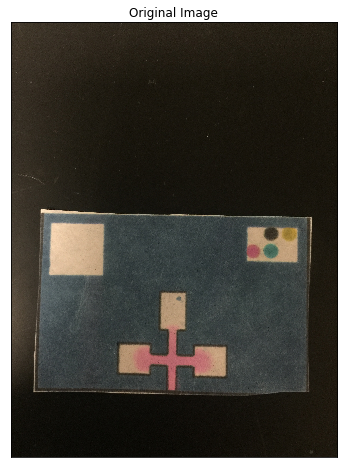

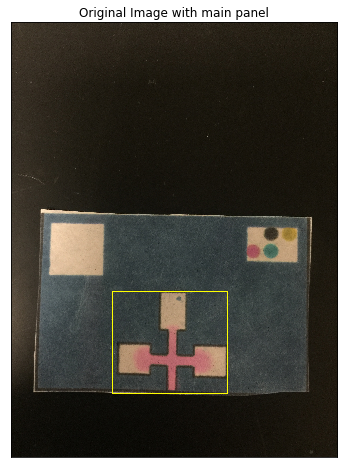

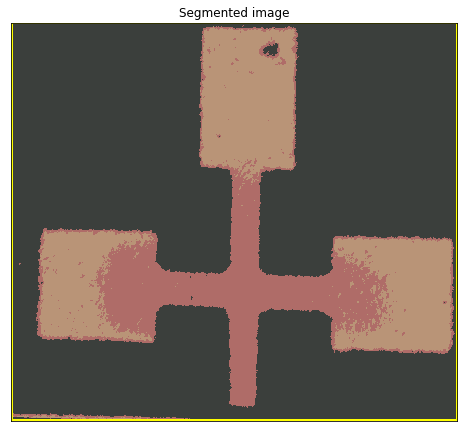

In [6]:
#Reading the image into variable
img = cv2.imread('original.jpg')

#Converting the image to RGB since OpenCv reads image in BGR format
rgbimg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(rgbimg,cmap= 'gray')

#Converting the image to HSV space to account for different lightning conditions
hsvimg = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2HSV)

#Apply Gaussian filter to remove noise.Uisng Saturation component to apply threshold on the gray scale part
blur = cv2.GaussianBlur(hsvimg[:,:,1],(11,11),2)

#Kernel for morphological transformations 
kernel = np.ones((7,7),np.uint8)

#Apply Otsu's threshold
retval2,threshold2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#opening = cv2.morphologyEx(threshold2, cv2.MORPH_CLOSE, kernel, iterations = 2)

#Find contours in the threshold image
retval, contours, hierarchy = cv2.findContours(threshold2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#Plot contours as rectangularboxes
if contours is not None:
    
    for contour in contours:
        
        #Filter out small contours due to noise by applying condition on the minimum area
        if cv2.contourArea(contour) > 5000:
            
            #Get the bounding box for the contours
            x,y,w,h = cv2.boundingRect(contour)
           
            #Consider only contours which are near square 
            if w/h >0.8 and w/h < 1.2:
                
                #Since the main panelis in the center, filtering for contours only in the middle of the image
                if x > rgbimg.shape[1]/4 and x < rgbimg.shape[1]*3/4:
                    #Draw rectagle in the required region
                    cv2.rectangle(rgbimg,(int(x),int(y)),(int(x+w),int(y+h)),(255,255,0),5)
                    
                    fig = plt.figure(figsize = (8,8))
                    ax1 = fig.add_subplot(111)
                    ax1.set_xticks([])
                    ax1.set_yticks([])

                    ax1.set_title('Original Image with main panel detected')
                    ax1.imshow(rgbimg,cmap= 'gray')
                    
                    
                    
                    main_panel = contour
                    crop_img = rgbimg[y:y+h,x:x+w]
                    # Reshape image into a 2D array of pixels and 3 color values (RGB)
                    pixel_vals = crop_img.reshape((-1,3))
                    #Applying k-Means to cluster the image into different colour segments and then extract the ink colour
                    # Convert to float type
                    pixel_vals = np.float32(pixel_vals)
                    # define stopping criteria
                    # you can change the number of max iterations for faster convergence!
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

                    #Select a value for k
                    # then perform k-means clustering
                    #Choosing the number ofcluster as 4 based on trial and error
                    k = 4
                    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

                    # convert data into 8-bit values
                    centers = np.uint8(centers)
                    segmented_data = centers[labels.flatten()]

                    # reshape data into the original image dimensions
                    segmented_image = segmented_data.reshape((crop_img.shape))
                    labels_reshape = labels.reshape(crop_img.shape[0], crop_img.shape[1])
                    
                    fig = plt.figure(figsize = (8,8))
                    ax1 = fig.add_subplot(111)
                    ax1.set_xticks([])
                    ax1.set_yticks([])

                    ax1.set_title('Color Segmented image of main panel')
                    ax1.imshow(segmented_image)
                    
                    




The center colour of the ink region returned by k-Means is: [175 108 104]


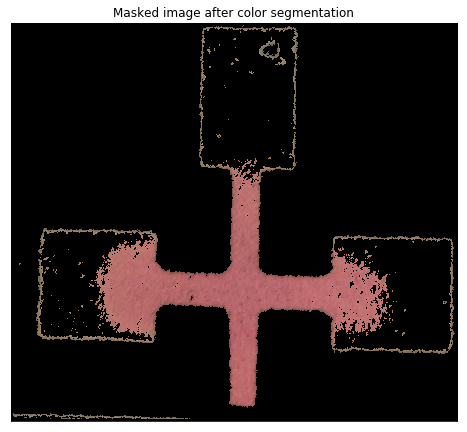

In [23]:
#Cluster for ink color is 1. Chosen after seeing the results for all four clusters.May change when executed later.
cluster = 1

#Make a copy of the cropped image and apply the color segment mask on the cropped image to get the only the ink region
masked_image = np.copy(crop_img)
# turn the remaining pixels to 0
masked_image[labels_reshape != cluster] = [0, 0, 0]

#Printing the center region returned by k-Means for ink region
print('The center colour of the ink region returned by k-Means is: ' + str(centers[1]))

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Masked image after color segmentation')
ax1.imshow(masked_image, cmap = 'gray')


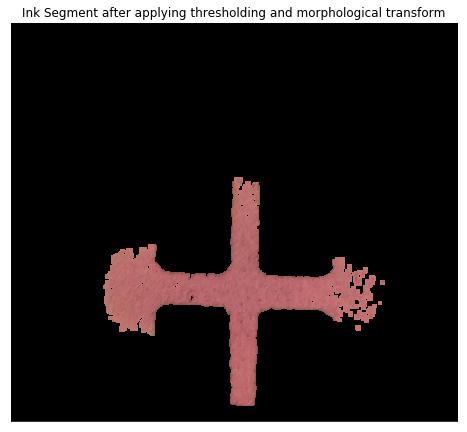

In [18]:
#Applying some thresholding on the color segmented image to remove noisy patches
hsv_mask = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)
hue_img = hsv_mask[:,:,1]
retval_segment,threshold_segment = cv2.threshold(hue_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(threshold_segment, cv2.MORPH_OPEN, kernel, iterations = 2)
masked_image_segment = np.copy(crop_img)
masked_image_segment[opening == 0] = [0, 0, 0]

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Ink Segment after applying thresholding and morphological transform')
ax1.imshow(masked_image_segment, cmap = 'gray')


In [16]:
#Calculating the Average ink colour
masked_copy_segment = np.copy(masked_image_segment)
red_masked_segment = masked_copy_segment[:,:,0]
green_masked_segment = masked_copy_segment[:,:,1]
blue_masked_segment = masked_copy_segment[:,:,2]
red_flat_segment = red_masked_segment.flatten()
green_flat_segment = green_masked_segment.flatten()
blue_flat_segment = blue_masked_segment.flatten()
red_mean_segment = np.sum(red_flat_segment)/np.count_nonzero(red_flat_segment)
green_mean_segment = np.sum(green_flat_segment)/np.count_nonzero(green_flat_segment)
blue_mean_segment = np.sum(blue_flat_segment)/np.count_nonzero(blue_flat_segment)
avg_ink_color = [int(red_mean_segment), int(green_mean_segment), int(blue_mean_segment)]
print('The average ink color is: ' + str(avg_ink_color))

The average ink color is: [181, 104, 105]
